### Ce notebook traite les données de comptage annuelles de trafic routier de Montpellier Métropole
et 
 in : https://data.montpellier3m.fr/dataset/comptage-vehicules-particuliers-de-montpellier    
 out : CSV des comptages MJA jo et tcj par année, HP matin soir, taux d'irrespect Vmax, Vt, débit PL
 

## 0. initialisations

In [42]:
# pipeline parameters (values will be replaced by papermill when you run the compute.sh script in a docker container, or launch the pipeline)
# the parameters below are used when you test the notebook on jupyter 
# because this cell has a tag "parameters" https://papermill.readthedocs.io/en/latest/usage-parameterize.html
# you will have to download the data beforehand in the directories 
# pour ce notebook on n'utilise pas download.sh ne fait rien, on télécharge les données dans le notebook
# donc SOURCE_DIR ne sert à rien mais il faut que le directory indiqué existe sinon le pipeline plante.
PARAMETER_PROFILE_FILE="../3Mdata/3M.json"
SOURCE_DIR = "../3Mdata"
TARGET_DIR = "../3Mdata/trafic"
debug=False

In [4]:
import sys
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(format="%(levelname)s:%(name)s:%(asctime)s:%(message)s",level=logging.WARNING,stream=sys.stdout)
# Use stderr if script outputs data to stdout.

In [5]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import geopandas as gpd
#import matplotlib


In [6]:

import shapely

gpd.options.use_pygeos = True
from pygeos.io import from_wkt

if debug:
    import folium


## 1. lecture des comptages routiers
URL en dur pour l'instant, sans fichier de paramètres

In [7]:
COMPTAGES_URL="https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MTP_Comptage.csv"
FILAIRE_URL="https://data.montpellier3m.fr/sites/default/files/ressources/OSM_MMM_CorrespondanceFilaire.geojson"

In [8]:
COMPTAGES = pd.read_csv(COMPTAGES_URL)

## 1.1. Calcul de moyennes annuelles
https://r4ds.had.co.nz/tidy-data.html
    Each variable must have its own column.
    Each observation must have its own row.
    Each value must have its own cell.

In [9]:
#COMPTAGES.shape
# 9552 lignes COMPTAGES
#COMPTAGES[COMPTAGES['libelle_groupage']=='Sens cumulés'].shape
#2409 lignes concernent des chiffres en sens cumulés
# mais en fait on veut aussi les libelle_groupage des voies en sens unique (cf. ci-dessous)

In [10]:
# corrections d'erreurs typo
COMPTAGES['libelle_groupage'][(COMPTAGES['libelle_groupage']=="Sens Cumule") | (COMPTAGES['libelle_groupage']=="Sens Cumulé")]="Sens cumulés"

/tmp/ipykernel_67843/2801817833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  COMPTAGES['libelle_groupage'][(COMPTAGES['libelle_groupage']=="Sens Cumule") | (COMPTAGES['libelle_groupage']=="Sens Cumulé")]="Sens cumulés"


In [11]:
# nettoyage des données : on ne garde que les valeurs de code_centrale qui sont des entiers (et peuvent donc correspondre à un gid de tronçon)
# ou gid+V/V1/V2 (comptages vélo, cf. https://gitlab.com/open-mobility-indicators/tomm/-/wikis/Description-des-mesures-de-trafic)
# on enlève les autres lignes (ce sont en principe des mesures de test)
COMPTAGES['code_velo']=COMPTAGES['code_centrale'].apply(lambda x: x[x.index('V',len(x)-2):] if (x[-2]=='V') or (x[-1]=='V') else "")

In [12]:
# on enlève ensuite le suffixe V,V1 ou V2 des code_centrale (on crée une colonne code_velo qui contient ce suffixe)
COMPTAGES['gid']=COMPTAGES['code_centrale'].apply(lambda x: x[:x.index('V',len(x)-2)] if (x[-2]=='V') or (x[-1]=='V') else x)

In [13]:
COMPTAGES['gid']=COMPTAGES['gid'].apply(lambda x: int(x) if x.isdigit() else "texte")
# il reste 9421 lignes sur 9552 (et 131 'texte')
COMPTAGES=COMPTAGES[COMPTAGES['gid']!='texte']

In [14]:
#COMPTAGES['libelle_groupage'].isna().sum()
# il y 30 libelle groupage non renseignés


In [15]:
COMPTAGES.columns

Index(['objectid', 'nom_voie', 'id_centrale', 'code_centrale', 'id_canal',
       'code_canal', 'libelle_groupage', 'annee', 'horodate',
       'descriptif_periode', 'hp_johvs_matin', 'hp_johvs_soir', 'mja_jo',
       'mja_tcj', 'tir_tcj', 'v85ma_tcj', 'vtma_tcj', 'mja_pl_tcj',
       'objectid_publication', 'code_velo', 'gid'],
      dtype='object')

In [16]:
#code_centrale=list(COMPTAGES.code_centrale)
#id_centrale=list(COMPTAGES.id_centrale)
#code_canal=list(COMPTAGES.code_canal)
#horodate=list(COMPTAGES.horodate)
#descriptif_periode=list(COMPTAGES.descriptif_periode)

In [17]:
#len(set(code_centrale))
#len(set(code_canal))
#len(set(horodate))
#len(set(descriptif_periode))
#len(set(id_centrale))
# 1513 valeurs de code_centrale, 1511 valeurs de id_centrale... 9552 lignes
# 10 valeurs de code_canal, 0 à 8 + Z pour sens cumulés
# 2203 horodates, 1853 descriptif période


In [18]:
#(COMPTAGES['objectid'].isin(liste_id)).sum()
# 614 lignes correspondant à des tronçons à sens unique

In [19]:
liste_libelles=COMPTAGES.groupby('code_centrale').agg({"libelle_groupage": set,"objectid": list})
# pour chaque code_centrale, ensemble des valeurs de libellé et liste des id correspondants
# on veut ajouter aux mesures de libellé "sens cumulés" celle qui n'ont qu'une valeur de libellé, et qui correspondent à un sens unique en principe
liste_libelles["nb_libellés"]=liste_libelles['libelle_groupage'].apply(lambda x: len(x))
liste_id=liste_libelles[liste_libelles.nb_libellés==1].objectid.sum()

In [20]:
#COMPTAGES[(COMPTAGES['code_canal']=='Z') & (COMPTAGES['libelle_groupage']=='Sens cumulés')
# le code_canal Z correspond aux sens cumulés en principe

In [21]:
# on ne garde que le cumul des comptages dans les 2 sens ou les comptages détectés ci-dessus comme correspondant à un tronçon en sens unique
# soit 2996 lignes sur 9231
MM=COMPTAGES[(COMPTAGES['libelle_groupage']=='Sens cumulés') | (COMPTAGES['objectid'].isin(liste_id))][['nom_voie', 'id_centrale', 'gid', 'code_centrale',  
        'id_canal','code_canal', 'libelle_groupage', 'annee', 'horodate',
       'descriptif_periode', 'hp_johvs_matin', 'hp_johvs_soir', 'mja_jo',
       'mja_tcj', 'tir_tcj', 'v85ma_tcj', 'vtma_tcj', 'mja_pl_tcj']]

In [22]:
MM['annee']=MM.annee.apply(lambda x: str(x)[0:4])

In [23]:
# on enlève les données antèrieures à 2016
# il reste 1498 lignes (vs. 1944 lignes au total)
MM=MM[MM["annee"]>"2015"]

In [24]:
# la moyenne est très simplifiée ; on ne pondère pas la moyenne selon le nb de jours de chaque période (ligne du dataframe MM) 
#     rentrant dans le calcul de la moyenne
MMan=MM.groupby(['code_centrale','annee']).agg({'gid': ['mean'], 'hp_johvs_matin': [np.mean], 'hp_johvs_soir':[np.mean], 'mja_jo':[np.mean], 'mja_tcj':[np.mean], 'tir_tcj':[np.mean], 'vtma_tcj': [np.mean], 'mja_pl_tcj': [np.mean]})

In [25]:
# on regroupe les lignes par année et on calcule la moyenne, pour chaque indicateur (colonne)
# c'est très approximatif : il faudrait faire les calculs sur les données initiales en base, idéalement ; à voir si on a le temps plus tard
# la table a beaucoup de valeurs vides ; il faudrait peut être produire une donnée CSV différente, par exemple par indicateur, en ne gardant que les années avec des données


In [26]:
MMan=MMan.droplevel(1, axis=1) 
MMan=MMan.reset_index()

In [27]:
#MMan[MMan.mja_pl_tcj.notna()]

### 1.3 ajout du type de centrale

In [28]:
TOMM_CENTRALE_URL="https://testpg.pagesperso-orange.fr/files/tomm_centrale.csv"
tomm_centrale=pd.read_csv(TOMM_CENTRALE_URL)
# récupération d'un fichier CSV exporté au préalable depuis la BD mivisu postgresql

In [29]:
#tomm_centrale[tomm_centrale['code_centrale']=='30917']
#il y a un doublon, on enlève id_centrale=648 (qui a des mesures en 2013 et 2014 qu'on ne traite pas)

In [30]:
#tomm_centrale[tomm_centrale['id_centrale']==648]

In [31]:
tomm_centrale.drop(tomm_centrale.loc[tomm_centrale['id_centrale']==648].index, inplace=True)

In [32]:
MMan = tomm_centrale[['code_centrale','libelle_centrale','libelle_type_centrale']].merge(MMan, on='code_centrale')

## 1.2. lecture du filaire de voirie, association aux comptages

In [33]:
FILAIRE=gpd.read_file(FILAIRE_URL)

In [34]:
FILAIRE.columns

Index(['objectid', 'gid', 'tag_id', 'name', 'rule', 'one_way', 'oneway',
       'priority', 'access', 'alt_name', 'area', 'barrier', 'bicycle',
       'bridge', 'constructi', 'covered', 'cycleway', 'cycleway_b',
       'cycleway_l', 'cycleway_r', 'foot', 'highway', 'junction', 'lanes',
       'lanes_back', 'lanes_forw', 'lanes_psv', 'lanes_psv_', 'lanes_psv1',
       'layer', 'maxheight', 'maxspeed', 'psv', 'railway', 'ref', 'ref_mmm',
       'service', 'sidewalk', 'status', 'surface', 'tracktype', 'traffic_ca',
       'tunnel', 'turn_lanes', 'wheelchair', 'zone_maxsp', 'code_insee',
       'nom_commun', 'cycles', 'osm_id', 'maxspeed_f', 'maxspeed_b',
       'st_length_', 'geometry'],
      dtype='object')

In [35]:
comptages_an = FILAIRE[['gid','name','one_way','lanes','maxspeed','nom_commun','st_length_','geometry']].merge(MMan, on='gid')

In [36]:
# les tronçons de voirie (contenus dans geometry) sont des multilinestrings shapely, avec un seul linestring
def milieu(ls):
    l=list(ls.coords)
    return shapely.geometry.Point(l[int(len(l)/2)][0],l[int(len(l)/2)][1])

In [37]:
# la colonne point_mesure définit la position x,y du "milieu" du tronçon (au sens du point intermédiaire dans la liste des points qui définit le tronçon
#, pas forcément le vrai milieu en abscisse linéaire sur le tronçon)
comptages_an['point_mesure']=comptages_an.apply(lambda x: milieu(x.geometry[0]),axis=1)

In [38]:
comptages_an=comptages_an.reset_index(level=0)

In [39]:
comptages_an=comptages_an.rename(columns={"name": "voie", "nom_commun": "commune","lanes": "nb_voies","st_length_": "longueur", "maxspeed": "vmax", "libelle_type_centrale": "type_centrale"}) 

In [40]:
comptages_an['X']=comptages_an.point_mesure.apply(lambda x: (x.coords)[0][0]) #lon
comptages_an['Y']=comptages_an.point_mesure.apply(lambda x: (x.coords)[0][1]) #lat
comptages_an=comptages_an.drop('point_mesure',axis=1)

<AxesSubplot:>

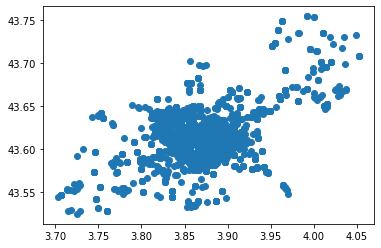

In [65]:
#PM=gpd.GeoDataFrame(comptages_an[['point_mesure']],geometry='point_mesure')
#PM.plot()

In [57]:
#comptages_an.plot()

<AxesSubplot:>

In [59]:
#comptages_an.columns

Index(['index', 'gid', 'voie', 'one_way', 'nb_voies', 'vmax', 'commune',
       'longueur', 'geometry', 'code_centrale', 'libelle_centrale',
       'libelle_type_centrale', 'annee', 'hp_johvs_matin', 'hp_johvs_soir',
       'mja_jo', 'mja_tcj', 'tir_tcj', 'vtma_tcj', 'mja_pl_tcj', 'X', 'Y'],
      dtype='object')

## 1.3 export CSV (les géom sont exportées en WKT)

In [43]:
comptages_an[['index', 'gid', 'annee','type_centrale','voie', 'commune',
       'hp_johvs_matin','hp_johvs_soir', 'mja_jo', 'mja_tcj', 'tir_tcj', 'vtma_tcj','mja_pl_tcj', 
       'X', 'Y','geometry','libelle_centrale','one_way', 'nb_voies', 'longueur', 'vmax' ]].to_csv(f"{TARGET_DIR}/comptages3M.csv", index=False)